<a href="https://colab.research.google.com/github/LidiiaMelnyk95/phdproject/blob/main/biLSTM_stance_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import MaxPooling1D, Dropout, Activation, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import warnings

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.7.0


In [2]:
if os.environ.get('COLAB_GPU', False):
    !pip install -U holoviews hvplot panel==0.8.1

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 1.3 MB 44.5 MB/s 
     |████████████████████████████████| 32.4 MB 1.2 MB/s 
  Created wheel for bokeh: filename=bokeh-1.4.0-py3-none-any.whl size=23689209 sha256=7f5985d9938800f245a8bc7c246c76084046cf8e421bd9ca09c3e1cfeb0a183b
  Stored in directory: /root/.cache/pip/wheels/49/8c/d1/6b8e1f57e542671673cb3d2faee1a9eccb36be2c08a3915498
Successfully built bokeh
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.3.3
    Uninstalling bokeh-2.3.3:
      Successfully uninstalled bokeh-2.3.3
  Attempting uninstall: panel
    Found existing installation: panel 0.12.1
    Uninstalling panel-0.12.1:
      Successfully uninstalled panel-0.12.1


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
if os.environ.get('COLAB_GPU', False):
    from google.colab import drive
    drive.mount("/drive")

Mounted at /drive


In [7]:
df1 = pd.read_csv('trans_train.csv', sep = ';')

In [14]:
df1['Label'].value_counts()

__label__AGAINST    237
__label__NEUTRAL    225
__label__FAVOR      138
Name: Label, dtype: int64

In [16]:
import matplotlib.pyplot as plt

In [33]:
def print_plot(index):
  for i, row in df1.iterrows():
    for l in row['Text'].split('/n'):
      for m in row['Label'].split('/n'):
        if len(l) > 0:
          print(l)
          print('Label:', m)
print_plot(10)

stinger ist ne rechtfertigung wenn ich sage dass ich das nicht bse meinte und dass auch hoffentlich nicht ankam rechtfertigen wre pech ist doch meine sache ich sage das hab ich aber nicht ntig und da ich ein empathischer mensch bin stelle ich das gerne klar hat ja auch nie jemand verurteilt kam doch nur ein emoji
Label: __label__NEUTRAL
djmuede scherzkeks
Label: __label__NEUTRAL
amalie  ich zitiere mal aus dem artikel reportage der ultimativen quelle wikipedia idealerweise erzhlt er der reporter ohne dabei zu werten oder zu kommentieren auch nicht durch weglassen alle drei genannten punkte die idealerweise erfllt werden sollten sehe ich stellenweise oder gnzlich nicht erfllt
Label: __label__NEUTRAL
ylime das kann ich gut nachvollziehen wre auf jeden fall eine kompromisslsung
Label: __label__NEUTRAL
true super schn dass du marceljana supportest
Label: __label__FAVOR
de papa fragen die beim tv sich auch
Label: __label__NEUTRAL
steffen richter nope frag die wissenschaft es gibt weit mehr


In [34]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
df1 = df1.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df1['Text'] = df1['Text'].apply(clean_text)
df1['Text'] = df1['Text'].str.replace('\d+', '')

In [36]:
print_plot(10)

stinger ist ne rechtfertigung wenn ich sage dass ich das nicht bse meinte und dass auch hoffentlich nicht ankam rechtfertigen wre pech ist doch meine sache ich sage das hab ich aber nicht ntig und da ich ein empathischer mensch bin stelle ich das gerne klar hat ja auch nie jemand verurteilt kam doch nur ein emoji
Label: __label__NEUTRAL
djmuede scherzkeks
Label: __label__NEUTRAL
amalie ich zitiere mal aus dem artikel reportage der ultimativen quelle wikipedia idealerweise erzhlt er der reporter ohne dabei zu werten oder zu kommentieren auch nicht durch weglassen alle drei genannten punkte die idealerweise erfllt werden sollten sehe ich stellenweise oder gnzlich nicht erfllt
Label: __label__NEUTRAL
ylime das kann ich gut nachvollziehen wre auf jeden fall eine kompromisslsung
Label: __label__NEUTRAL
true super schn dass du marceljana supportest
Label: __label__FAVOR
de papa fragen die beim tv sich auch
Label: __label__NEUTRAL
steffen richter nope frag die wissenschaft es gibt weit mehr
L

In [37]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df1['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4639 unique tokens.


In [80]:
X = tokenizer.texts_to_sequences(df1['Text'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='pre',
    truncating='pre', value=0.0)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (600, 250)


In [81]:
Y = pd.get_dummies(df1['Label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (600, 3)


In [82]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(540, 250) (540, 3)
(60, 250) (60, 3)


In [87]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.1))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

In [88]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
8/8 [==============================] - 12s 854ms/step - loss: 1.0778 - accuracy: 0.4239 - val_loss: 0.9889 - val_accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 6s 780ms/step - loss: 0.9875 - accuracy: 0.5082 - val_loss: 0.9290 - val_accuracy: 0.5556
Epoch 3/10
8/8 [==============================] - 6s 795ms/step - loss: 0.9362 - accuracy: 0.5782 - val_loss: 0.9301 - val_accuracy: 0.4815
Epoch 4/10
8/8 [==============================] - 6s 799ms/step - loss: 0.8948 - accuracy: 0.6564 - val_loss: 0.9642 - val_accuracy: 0.5185
Epoch 5/10
8/8 [==============================] - 7s 842ms/step - loss: 0.8142 - accuracy: 0.7243 - val_loss: 0.9216 - val_accuracy: 0.5370
Epoch 6/10
8/8 [==============================] - 11s 1s/step - loss: 0.6921 - accuracy: 0.7510 - val_loss: 0.9790 - val_accuracy: 0.5185
Epoch 7/10
8/8 [==============================] - 6s 796ms/step - loss: 0.5228 - accuracy: 0.8169 - val_loss: 1.1020 - val_accuracy: 0.5370
Epoch 8/10
8/8 [=====

In [93]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2/2 [==============================] - 0s 145ms/step - loss: 1.2761 - accuracy: 0.4500
Test set
  Loss: 1.276
  Accuracy: 0.450


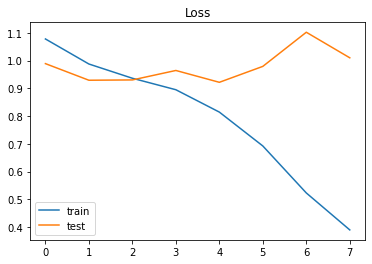

In [91]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

KeyError: ignored

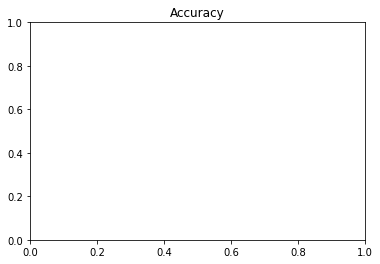

In [95]:
plt.title('Accuracy')
plt.plot(history.history['accr'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [106]:
new_complaint = ['ich habe nichts verstanden']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['__label__AGAINST', '__label__NEUTRAL', '__label__FAVOR']
print(pred, labels[np.argmax(pred)])

[[0.19968438 0.01319008 0.7871255 ]] __label__FAVOR
